<a href="https://colab.research.google.com/github/devpranoy/Dental-Biometrics/blob/master/Dental_Biometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dental Biometrics

In [85]:
#connecting google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [86]:
!ls /content/drive/My\ Drive/DentalPanoramicXrays/Images


100.png  112.png  19.png  30.png  42.png  54.png  66.png  78.png  8.png
101.png  113.png  1.png   31.png  43.png  55.png  67.png  79.png  90.png
102.png  114.png  20.png  32.png  44.png  56.png  68.png  7.png   91.png
103.png  115.png  21.png  33.png  45.png  57.png  69.png  80.png  92.png
104.png  116.png  22.png  34.png  46.png  58.png  6.png   81.png  93.png
105.png  11.png   23.png  35.png  47.png  59.png  70.png  82.png  94.png
106.png  12.png   24.png  36.png  48.png  5.png   71.png  83.png  95.png
107.png  13.png   25.png  37.png  49.png  60.png  72.png  84.png  96.png
108.png  14.png   26.png  38.png  4.png   61.png  73.png  85.png  97.png
109.png  15.png   27.png  39.png  50.png  62.png  74.png  86.png  98.png
10.png	 16.png   28.png  3.png   51.png  63.png  75.png  87.png  99.png
110.png  17.png   29.png  40.png  52.png  64.png  76.png  88.png  9.png
111.png  18.png   2.png   41.png  53.png  65.png  77.png  89.png


##Load the necessary packages

In [0]:
import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

##Loading Sample Dataset

In [0]:
def load_image(src):
  img=mpimg.imread(src)
  plt.axis('off')
  plt.imshow(img)


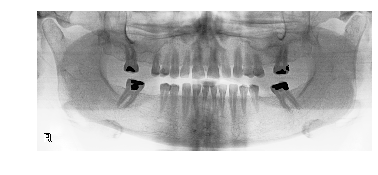

In [89]:
data_dir = "/content/drive/My Drive/DentalPanoramicXrays/Images/"
load_image(data_dir+str(10)+'.png')

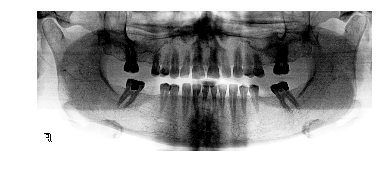

In [90]:
#Enhancing for processing
img=mpimg.imread(data_dir+'%d.png'%(10))
plt.axis('off')
imgplot = plt.imshow(img, clim=(0.09, 0.7))

Importing the dataset

In [0]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torchvision.models as models



## Specify appropriate transforms, and batch_sizes

batch_size = 4
num_workers = 0

data_dir = '/content/drive/My Drive/dental_data'
train_dir = os.path.join(data_dir, 'train/')
valid_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'train/')


In [0]:
standard_normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
    
                                     transforms.Grayscale(num_output_channels=3),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'val': transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.Grayscale(num_output_channels=3),
                                     transforms.ToTensor(),
                                     standard_normalization]),
                   'test': transforms.Compose([transforms.Resize(size=(224,224)),
                                     transforms.Grayscale(num_output_channels=3),
                                     transforms.ToTensor(), 
                                     standard_normalization])
                  }

In [0]:
train_data = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
valid_data = datasets.ImageFolder(valid_dir, transform=data_transforms['val'])
test_data = datasets.ImageFolder(test_dir, transform=data_transforms['test'])


In [0]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=batch_size, 
                                           num_workers=num_workers,
                                           shuffle=False)
loaders_transfer = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

In [0]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Define Architecture for Transfer Learning Resnet50

In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

num_classes = 4 # total classes of teeth here incisor, canine, premolar, molar

In [0]:
import torchvision.models as models
import torch.nn as nn
#Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

In [0]:

for param in model_transfer.parameters():
    param.requires_grad = False

In [0]:
model_transfer.fc = nn.Linear(2048, 4, bias=True)

In [0]:
fc_parameters = model_transfer.fc.parameters()

In [0]:
for param in fc_parameters:
    param.requires_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()

In [0]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

# Training 

In [0]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [104]:
train(30, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch 1, Batch 1 loss: 1.134382
Epoch 1, Batch 101 loss: 1.323762
Epoch 1, Batch 201 loss: 1.308909
Epoch 1, Batch 301 loss: 1.271209
Epoch 1, Batch 401 loss: 1.266185
Epoch: 1 	Training Loss: 1.266673 	Validation Loss: 1.136360
Validation loss decreased (inf --> 1.136360).  Saving model ...
Epoch 2, Batch 1 loss: 1.389541
Epoch 2, Batch 101 loss: 1.201639
Epoch 2, Batch 201 loss: 1.216373
Epoch 2, Batch 301 loss: 1.208921
Epoch 2, Batch 401 loss: 1.199430
Epoch: 2 	Training Loss: 1.197077 	Validation Loss: 1.092807
Validation loss decreased (1.136360 --> 1.092807).  Saving model ...
Epoch 3, Batch 1 loss: 1.030184
Epoch 3, Batch 101 loss: 1.161217
Epoch 3, Batch 201 loss: 1.163916
Epoch 3, Batch 301 loss: 1.173056
Epoch 3, Batch 401 loss: 1.176770
Epoch: 3 	Training Loss: 1.172757 	Validation Loss: 1.065640
Validation loss decreased (1.092807 --> 1.065640).  Saving model ...
Epoch 4, Batch 1 loss: 0.653961
Epoch 4, Batch 101 loss: 1.129899
Epoch 4, Batch 201 loss: 1.138702
Epoch 4, Ba

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [107]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.914770


Test Accuracy: 60% (1011/1670)


Class label Generation 

In [0]:
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]
from PIL import Image
import torchvision.transforms as transforms

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.Grayscale(num_output_channels=3),
                                     transforms.ToTensor(), 
                                     standard_normalization])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [0]:

def predict_teeth_transfer(model, class_names, img_path):
    # load the image and return the predicted teeth 
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    idx = torch.argmax(model(img))
    return class_names[idx]

Testing on Incisors

In [110]:
for img_file in os.listdir('/content/drive/My Drive/dental_data/train/002.Incisors'):
    img_path = os.path.join('/content/drive/My Drive/dental_data/train/002.Incisors', img_file)
    predition = predict_teeth_transfer(model_transfer, class_names, img_path)
    print("image_file_name: {0}, \t Teeth Prediction: {1}".format(img_path, predition))

image_file_name: /content/drive/My Drive/dental_data/train/002.Incisors/49Layer 1.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/002.Incisors/104Layer 3.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/002.Incisors/84Layer 4.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/002.Incisors/58Layer 3.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/002.Incisors/50Layer 5.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/002.Incisors/95Layer 6.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/002.Incisors/76Layer 7.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/002.Incisors/98Layer 5.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/002.Incisors/8

KeyboardInterrupt: ignored

Testing on Canines

In [111]:
for img_file in os.listdir('/content/drive/My Drive/dental_data/train/001.Canines'):
    img_path = os.path.join('/content/drive/My Drive/dental_data/train/001.Canines', img_file)
    predition = predict_teeth_transfer(model_transfer, class_names, img_path)
    print("image_file_name: {0}, \t Teeth Prediction: {1}".format(img_path, predition))

image_file_name: /content/drive/My Drive/dental_data/train/001.Canines/58Layer 3.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/001.Canines/49Layer 1.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/001.Canines/84Layer 4.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/001.Canines/104Layer 3.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/001.Canines/73Layer 2.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/001.Canines/81Layer 1.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/001.Canines/110Layer 4.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/001.Canines/90Layer 3.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/001.Canines/90Layer 2.png

OSError: ignored

Testing on Premolars

In [112]:
for img_file in os.listdir('/content/drive/My Drive/dental_data/train/004.Premolars'):
    img_path = os.path.join('/content/drive/My Drive/dental_data/train/004.Premolars', img_file)
    predition = predict_teeth_transfer(model_transfer, class_names, img_path)
    print("image_file_name: {0}, \t Teeth Prediction: {1}".format(img_path, predition))

image_file_name: /content/drive/My Drive/dental_data/train/004.Premolars/38Layer 5.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/004.Premolars/86Layer 2.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/004.Premolars/43Layer 1.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/004.Premolars/65Layer 3.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/004.Premolars/71Layer 4.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/004.Premolars/79Layer 2.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/004.Premolars/76Layer 10.png, 	 Teeth Prediction: Premolars
image_file_name: /content/drive/My Drive/dental_data/train/004.Premolars/74Layer 1.png, 	 Teeth Prediction: Incisors
image_file_name: /content/drive/My Drive/dental_data/train/004.Premo

KeyboardInterrupt: ignored

Testing on Molars

In [113]:
for img_file in os.listdir('/content/drive/My Drive/dental_data/train/003.Molars'):
    img_path = os.path.join('/content/drive/My Drive/dental_data/train/003.Molars', img_file)
    predition = predict_teeth_transfer(model_transfer, class_names, img_path)
    print("image_file_name: {0}, \t Teeth Prediction: {1}".format(img_path, predition))

image_file_name: /content/drive/My Drive/dental_data/train/003.Molars/58Layer 3.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/003.Molars/49Layer 1.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/003.Molars/104Layer 3.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/003.Molars/95Layer 6.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/003.Molars/84Layer 4.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/003.Molars/96Layer 8.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/003.Molars/50Layer 5.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/003.Molars/41Layer 7.png, 	 Teeth Prediction: Molars
image_file_name: /content/drive/My Drive/dental_data/train/003.Molars/67Layer 5.png, 	 Teeth Prediction

KeyboardInterrupt: ignored